<div style="text-align:center"><span style="font-size:2em; font-weight: bold;">Lecture 11--Time Series</span></div>

# Data Science: ARMA processes

## Foundation
### Definition

$$x_t=\rho_1x_{t-1}+\dots+\rho_px_{t-p}+e_t+\phi_1e_{t-1}+\dots+\phi_qe_{t-q}$$

### Simulation

In [16]:
import numpy as np
import pandas as pd

n = 1000
rho = np.array([0.75,0.05])
phi = np.array([0.25])
phi = np.concatenate((np.ones(1),phi))
m = max(len(rho),len(phi))
if len(rho)!=m: rho = np.concatenate((rho,np.zeros(shape=m-len(rho))))
if len(phi)!=m: phi = np.concatenate((phi,np.zeros(shape=m-len(phi))))
print(rho)
print(phi)

[0.75 0.05]
[1.   0.25]


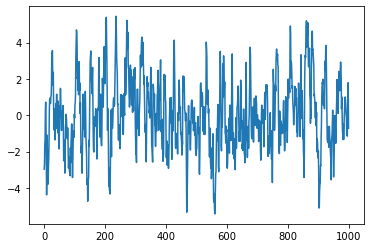

In [17]:
e = np.random.normal(size=n+100) ## 100 burn-in
x = e.copy()
for i in range(m,n+100):
    x[i] = np.flip(x[i-m:i])@rho+np.flip(e[i-m+1:i+1])@phi
x = x[100:] ## cut off the burn in
pd.Series(x).plot();

## State-space representation
### Format
$$s_t=\mathbf Fs_{t-1}+\mathbf Ge_t$$
$$x_t=\mathbf Hs_t+u_t$$

$$e_t\sim iid(0,\mathbf Q)$$
$$u_t\sim iid(0,\mathbf R)$$
$$e_t\perp u_t$$
### ARMA to state-space

$$\mathbf F = 
\begin{bmatrix}
\rho_{-1} & I_{m-1} \\
\rho_m & 0'
\end{bmatrix}
$$

$$\mathbf G = \begin{bmatrix}1,\phi'\end{bmatrix}'$$
where $\rho_{-1} = [\rho_1 \dots \rho_{m-1}]'$ and $\phi=[\phi_1\dots\phi_m]'$ and $m=\max\{p,q+1\}$


### Code

In [4]:
class state_space_model:
    def __init__(self,F,G,H,Q,R):
        self.F = F
        self.G = G
        self.H = H
        self.Q = Q
        self.R = R
    def from_arma(ar,ma,sig):
        r = max(ar.shape[0]-1,ma.shape[0])
        arr = np.zeros((r+1,))
        maa = np.zeros((r,))
        arr[:ar.shape[0]+1] = ar
        maa[:ma.shape[0]] = ma
        F = np.zeros((r+1,r+1))
        F[:,0] = arr
        F[:-1,1:] = np.eye(r)
        F = F.T
        G = np.hstack([1,maa]).reshape(-1,1)
        H = np.zeros((1,r+1))
        H[0,0] = 1
        Q = np.array([[state_space_model._get_Q_(ar,ma)]])
        R = np.array([[sig]])
        return state_space_model(F,G,H,Q,R)
    def _get_Q_(ar,ma):
        r = max(ar.shape[0],ma.shape[0])
        if ar.shape[0]<r:
            ar = np.hstack((ar,np.zeros(r-ar.shape[0])))
        if ma.shape[0]<r:
            ma = np.hstack((ma,np.zeros(r-ma.shape[0])))
        ma = np.hstack((1,ma))
        sigma = 1
        sigx = sigma*ma
        mat = np.eye(r+1)
        for i in range(r+1):
            mat[-1-i,:-i-1] = -ar[::-1][i:]
        sigx = np.linalg.solve(mat,sigx)
        mat = np.eye(r+1)
        rhs = np.zeros(r+1)
        for i in range(r+1):
            for j in range(1,r+1):
                mat[i,int(np.abs(i-j))] -= ar[j-1]
            for j in range(r-i+1):
                rhs[i] += ma[i+j]*sigx[j]
        long_run_vari = np.linalg.solve(mat,rhs)[0]
        return long_run_vari

## Kalman filter
### State space implications

$$s_{t+1|t} = \mathbf F s_{t|t}$$
$$x_{t+1|t} = \mathbf H s_{t+1|t}$$
$$\mathbf P_{t+1|t} = \mathbf F \mathbf P_{t|t} \mathbf F' + \mathbf G \mathbf Q \mathbf G'$$
where $\mathbf P_t$ is the variance of $s_t$
$$\mathbf V_{t+1|t} = \mathbf H\mathbf P_{t+1|t}\mathbf H'+\mathbf R$$
where $\mathbf V_t$ is the variance of $x_t$
$$\mathbf C_{t+1|t} = \mathbf H\mathbf P_{t+1|t}$$
where $\mathbf C_t$ is the covariance between $x_t$ and $s_t$
### Updating equations

$$
\begin{bmatrix}
s_{t+1} \\
x_{t+1}
\end{bmatrix}_{t+1}
\sim
\mathcal N
\left(
\begin{bmatrix}
s_{t+1|t} \\
x_{t+1|t}
\end{bmatrix},
\begin{bmatrix}
\mathbf P_{t+1|t} & \mathbf C_{t+1|t}' \\
\mathbf C_{t+1|t} & \mathbf V_{t+1|t}
\end{bmatrix}
\right)
$$

$$s_{t+1|t+1}=s_{t+1|t}+\mathbf C_{t+1|t}'\mathbf V_{t+1|t}^{-1}\left(x_{t+1}-x_{t+1|t}\right)$$
$$\mathbf P_{t+1|t+1}=\mathbf P_{t+1|t}-\mathbf C_{t+1|t}'\mathbf V_{t+1|t}^{-1}\mathbf C_{t+1|t}$$

### Code

In [18]:
class state_space_model:
    def __init__(self,F,G,H,Q,R):
        self.F = F
        self.G = G
        self.H = H
        self.Q = Q
        self.R = R
    def from_arma(ar,ma,sig):
        r = max(ar.shape[0]-1,ma.shape[0])
        arr = np.zeros((r+1,))
        maa = np.zeros((r,))
        arr[:ar.shape[0]+1] = ar
        maa[:ma.shape[0]] = ma
        F = np.zeros((r+1,r+1))
        F[-1,:] = np.flip(arr)
        F[:-1,1:] = np.eye(r)
        F = F.T
        G = np.hstack([1,maa]).reshape(-1,1)
        H = np.zeros((1,r+1))
        H[0,0] = 1
        Q = np.array([[state_space_model._get_Q_(ar,ma)]])
        R = np.array([[sig]])
        return state_space_model(F,G,H,Q,R)
    def _get_Q_(ar,ma):
        r = max(ar.shape[0],ma.shape[0])
        if ar.shape[0]<r:
            ar = np.hstack((ar,np.zeros(r-ar.shape[0])))
        if ma.shape[0]<r:
            ma = np.hstack((ma,np.zeros(r-ma.shape[0])))
        ma = np.hstack((1,ma))
        sigma = 1
        sigx = sigma*ma
        mat = np.eye(r+1)
        for i in range(r+1):
            mat[-1-i,:-i-1] = -ar[::-1][i:]
        sigx = np.linalg.solve(mat,sigx)
        mat = np.eye(r+1)
        rhs = np.zeros(r+1)
        for i in range(r+1):
            for j in range(1,r+1):
                mat[i,int(np.abs(i-j))] -= ar[j-1]
            for j in range(r-i+1):
                rhs[i] += ma[i+j]*sigx[j]
        long_run_vari = np.linalg.solve(mat,rhs)[0]
        return long_run_vari
    def kalman(self,series,init_state,init_var_state):
        n_obs,n_feat = series.shape
        n_state = init_state.shape[0]
        c_state = np.zeros((n_obs,n_state))
        c_series = np.zeros((n_obs,n_feat))
        c_var_state = np.zeros((n_obs,n_state,n_state))
        c_var_series = np.zeros((n_obs,n_feat,n_feat))
        c_cov = np.zeros((n_obs,n_feat,n_state))
        state = np.zeros((n_obs,n_state))
        act_var_state = np.zeros((n_obs,n_state,n_state))
        for i in range(n_obs):
            # Update conditional expectations
            if i==0:
                c_state[i,:] = self.F@init_state
                c_series[i,:] = self.H@c_state[i,:]
                c_var_state[i,:,:] = self.F@init_var_state@self.F.T + self.G@self.Q@self.G.T
            else:
                c_state[i,:] = self.F@state[i-1,:]
                c_series[i,:] = self.H@c_state[i,:]
                c_var_state[i,:,:] = self.F@act_var_state[i-1,:,:]@self.F.T + self.G@self.Q@self.G.T
            c_var_series[i,:,:] = self.H@c_var_state[i,:,:]@self.H.T+self.R
            c_cov[i,:,:] = self.H@c_var_state[i,:,:]
            # Update actual values
            update = np.linalg.solve(c_var_series[i,:,:],c_cov[i,:,:]).T
            state[i,:] = c_state[i,:] + update@(series[i,:]-c_series[i,:])
            act_var_state[i,:,:] = c_var_state[i,:,:]-update@c_cov[i,:,:]
        return(state,act_var_state,c_var_series)

### Estimation via CSS

Simply minimize the sum of the squared residuals from the resulting errors.

In [19]:
def css(arma,y,p):
    ar = arma[:p].flatten()
    ma = arma[p:].flatten()
    model = state_space_model.from_arma(ar,ma,1)
    P = np.linalg.inv(np.eye(2)-model.F)
    P = P@model.G@model.Q@model.G.T@P.T
    y = y.reshape(-1,1)
    z = y-y.mean()
    z = z/z.std()
    state,_,_ = model.kalman(z,np.zeros((2,)),P)
    res = z-state@model.H.T
    css = res.T@res
    return css.item()
def gradient(x,func,dx:float=0.000001):
    grad = []
    for i in range(x.shape[0]):
        x1 = x.copy()
        x1[i] += dx
        dy = func(x1)-func(x)
        grad += [dy/dx]
    return np.array(grad).flatten()
def gradient_descent(func,gradient,init_x:np.ndarray,learning_rate:float=0.05,max_reps:int=1000,maximize=False):
    x = init_x.copy()
    for i in range(max_reps):
        gx = gradient(x)
        x0 = x.copy()
        flast = func(x)
        x += gx*learning_rate if maximize else -gx*learning_rate
        if (func(x)<flast and maximize and i>2) or (func(x)>flast and (not maximize) and i>2): 
            x = x0
            break
        print(x,func(x))
    return x

In [20]:
gradient_descent(lambda i: css(i,x,2),
                 lambda j: gradient(j,lambda i: css(i,x,2)),
                 np.array([0.5,0,0]),
                 0.0001)

[0.52798837 0.0370397  0.02099126] 155.96219728206574
[0.56058496 0.07902574 0.04299456] 121.4325117279798
[0.59717509 0.12405264 0.06434826] 83.25945615922092
[0.63505943 0.16759469 0.08248288] 48.86251382853576
[0.6698238  0.20440552 0.09524075] 24.321556277131428
[0.69875179 0.23326494 0.10255575] 9.164176327775538
[0.72068817 0.25480589 0.10567304] 1.5635088838263154
[0.73234267 0.26635238 0.10626883] 0.005319735280910018
[0.73315336 0.26716264 0.10627101] 0.00031631459441050426
[0.73295259 0.26696185 0.10627114] 2.311142494150351e-05
[0.73300627 0.26701553 0.10627115] 1.5022627007671374e-06
[0.73299218 0.26700143 0.10627115] 1.2888457348442782e-07
[0.7329959  0.26700515 0.10627115] 3.4919552144861536e-09
[0.73299492 0.26700417 0.10627115] 2.6100476279464944e-09
[0.73299518 0.26700443 0.10627115] 4.859174105320229e-10


array([0.73299518, 0.26700443, 0.10627115])

In [21]:
0.73299518+0.26700443

0.9999996099999999

In [22]:
gradient_descent(lambda i: css(i,x,2),
                 lambda i: gradient(i,lambda j: css(j,x,2)),
                 np.array([0.75,0.15,0.2]),
                 learning_rate=0.0001)

[0.77027228 0.17033445 0.20373838] 5.0907080150152
[0.78504403 0.1849572  0.20539708] 1.511226021319981
[0.79426114 0.19410259 0.20592031] 0.2547736716390445
[0.79847651 0.19830404 0.2060124 ] 0.020657122939332518
[0.79974559 0.19957194 0.20602002] 0.0009451480934879704
[0.80002172 0.19984802 0.20602037] 3.457067362079091e-05
[0.80007457 0.19990087 0.20602039] 1.2302456210471438e-06
[0.80008438 0.19991068 0.20602039] 4.9766341960122463e-08
[0.80008619 0.19991249 0.20602039] 3.5451036766052615e-09
[0.80008653 0.19991282 0.20602039] 8.63855283861805e-10
[0.80008659 0.19991289 0.20602039] 5.680858226215436e-10
[0.8000866  0.1999129  0.20602039] 5.203143632007036e-10
[0.8000866  0.1999129  0.20602039] 5.117388958813614e-10
[0.8000866  0.1999129  0.20602039] 5.101661670426223e-10
[0.8000866  0.1999129  0.20602039] 5.098766063220348e-10
[0.8000866  0.1999129  0.20602039] 5.098232239453713e-10
[0.8000866  0.1999129  0.20602039] 5.098134349792582e-10
[0.8000866  0.1999129  0.20602039] 5.098116

array([0.8000866 , 0.1999129 , 0.20602039])

In [23]:
0.8000866+0.1999129

0.9999994999999999

### Estimation via Maximum likelihood

In [25]:
def likelihood(arma,y,p):
    ar = arma[:p].flatten()
    ma = arma[p:].flatten()
    model = state_space_model.from_arma(ar,ma,1)
    P = np.linalg.inv(np.eye(2)-model.F)
    P = P@model.G@model.Q@model.G.T@P.T
    y = y.reshape(-1,1)
    z = y-y.mean()
    z = z/z.std()
    state,vrst,vres = model.kalman(z,np.zeros((2,)),P)
    res = z-state@model.H.T
    rst = state[1:]-state[:-1]@model.F
    rst = rst@model.G@np.linalg.inv(model.G.T@model.G)
    css = np.diagflat((1/vres).flatten())@(res**2)
    vres = (vres>0).astype(int)*vres + 0.000001
    lnlike = css.mean()+np.log(vres).mean()+np.log(2*np.pi)
    lnlike = -lnlike/2
    return lnlike.item()

In [28]:
gradient_descent(lambda i: likelihood(i,x,2),
                 lambda i: gradient(i,lambda j: css(j,x,2)),
                 np.array([0.8000866 , 0.1999129 , 0.20602039]),
                 learning_rate=0.0001,
                 maximize=True)

[0.8000866  0.1999129  0.20602039] -7.936559199015278
[0.8000866  0.1999129  0.20602039] -7.936560541352483
[0.8000866  0.1999129  0.20602039] -7.936562968145639


array([0.8000866 , 0.1999129 , 0.20602039])

### Constraint

In [30]:
def constraint(ar,ma):
    poly = np.hstack([1,-ar])[::-1]
    roots = np.polynomial.polynomial.polyroots(poly)
    radii = np.array([np.absolute(x) for x in roots])
    return radii-1

In [31]:
constraint(np.array([0.8000866,0.1999129]),np.array([0.20602039]))

array([-8.00087017e-01, -4.16696883e-07])

##  Stationarity tests

### KPSS test

$$\mathcal H_0: \text{Series is stationary}$$
$$\mathcal H_1: \text{Series is nonstationary}$$

$$y_t=\beta_0+\beta_1 t+e_t$$
$$\hat S_t=\sum_{s=1}^t \hat e_s$$
$$\hat\eta=n^{-2}\sum_{t=1}^n \hat S_t^2$$
$$LM = \hat\eta\,\big/\,\hat\sigma_e^2$$
where $\hat\sigma_e^2$ is the estimated long-run variance of the residuals
### Dickey-Fuller test

$$\mathcal H_0: \text{Series is nonstationary}$$
$$\mathcal H_1: \text{Series is stationary}$$

$$\Delta y_t =\beta_0+\beta_1 t+\beta_2 y_{t-1} + \delta_1\Delta y_{t-1} +\dots+\delta_p\Delta y_{t-p}+e_t$$

$$\mathcal H_0 \cong \mathcal H_0':\beta_2=0 $$
### Code

In [33]:
import numpy as np
def kpss(series,trend=False,lagshort=True):
    y = series.values if type(series)==pd.Series else series
    n = y.shape[0]
    if lagshort: 
        lags = int(4*(n/100)**0.25)
    else: 
        lags = int(12*(n/100)**0.25)
    y = y.reshape(-1,1)
    x = np.ones((n,1))
    if trend:
        x = np.hstack((x,np.arange(n).reshape(-1,1)))
        table = np.array([0.119,0.146,0.176,0.216])
    else:
        table = np.array([0.347,0.463,0.574,0.739])
    tablep = np.array([0.1,0.05,0.025,0.01])
    res = y-x@np.linalg.solve(x.T@x,x.T@y)
    s = res.cumsum(0)
    eta = s.T@s/n**2
    sig = [2*(1-i/(lags+1))*(res[i:,:].T@res[:res.shape[0]-i,:])[0,0]/res[i:,:].shape[0] for i in range(1,lags+1)]
    sig = np.array(sig).sum()
    sig += (res.T@res)[0,0]/res.shape[0]
    stat = eta/sig
    stat = stat.item()
    p = np.interp(stat,table,tablep)
    df = pd.DataFrame(columns=['method','stat','lags','p'])
    df.loc[0] = ['kpss',stat,lags,p]
    return df
def adf(series,lags=None,explosive=False):
    y = series.values if type(series)==pd.Series else series
    n = y.shape[0]
    if lags is None: lags=int((n-1)**(1/3))
    y = y.reshape(-1,1)
    dy = y[1:,:]-y[:-1,:]
    ly = y[lags:-1,:]
    n -= lags+1
    ymat = dy[lags:,:]
    xmat = [dy[lags-i:-i,:].reshape(-1,1) for i in range(1,lags+1)]
    xmat = np.hstack((ly,np.ones((n,1)),np.arange(n).reshape(-1,1),*xmat))
    b = np.linalg.solve(xmat.T@xmat,xmat.T@ymat)
    e = ymat-xmat@b
    vb = (e.T@e/n)*np.linalg.inv(xmat.T@xmat)
    stat = b.flatten()/np.sqrt(np.diagonal(vb))
    stat = stat[0]
    method = 'adf'
    table = [[4.38, 4.15, 4.04, 3.99, 3.98, 3.96],\
        [3.95, 3.8 , 3.73, 3.69, 3.68, 3.66],\
        [3.6 , 3.5 , 3.45, 3.43, 3.42, 3.41],\
        [3.24, 3.18, 3.15, 3.13, 3.13, 3.12],\
        [1.14, 1.19, 1.22, 1.23, 1.24, 1.25],\
        [0.8 , 0.87, 0.9 , 0.92, 0.93, 0.94],\
        [0.5 , 0.58, 0.62, 0.64, 0.65, 0.66],\
        [0.15, 0.24, 0.28, 0.31, 0.32, 0.33]]
    tableT = np.array([25, 50, 100, 250, 500, 10000])
    tablep = np.array([0.01,0.025,0.05,0.10,0.90,0.95,0.975,0.88])
    tableilp = []
    ntmp = n
    if n > tableT.max(): 
        ntmp = tableT.max()
    for row in table:
        tableilp += [np.interp(ntmp,tableT,np.array(row))]
    tableilp = -np.array(tableilp)
    p = np.interp(stat,tableilp,tablep)
    if explosive:
        p = 1-p
    df = pd.DataFrame(columns=['method','explosive','stat','lags','p'])
    df.loc[0] = ['adf',explosive,stat,lags,p]
    return df

In [34]:
kpss(x)

,method,stat,lags,p
0,kpss,0.185034,7,0.1


In [35]:
adf(x)

,method,explosive,stat,lags,p
0,adf,False,-8.073817,9,0.01


In [12]:
np.diff(x.reshape(-1,1),0)

array([[-1.64431309],
       [-1.17161047],
       [-2.19420163],
       [-1.27069544],
       [ 0.22257095],
       [-0.71437105],
       [-0.89417097],
       [-1.19782032],
       [-1.06375322],
       [-0.64506069],
       [-1.07896056],
       [-1.35809842],
       [-3.47518905],
       [-3.66482932],
       [-1.74545538],
       [ 0.76256837],
       [-0.90753219],
       [-1.97794299],
       [-1.98949341],
       [-2.08659465],
       [-0.67481691],
       [-1.07431422],
       [-1.9191783 ],
       [-0.22492452],
       [-0.39829793],
       [-1.00294272],
       [ 0.40467307],
       [ 2.01457245],
       [ 0.47621795],
       [ 0.91414354],
       [ 1.46780357],
       [-0.17365957],
       [-1.17968584],
       [ 1.35377612],
       [ 1.30861087],
       [ 0.52773379],
       [ 1.84180671],
       [ 2.21188408],
       [ 1.76592381],
       [ 3.1684942 ],
       [ 3.16725596],
       [ 2.2343702 ],
       [ 3.02976991],
       [ 1.04068407],
       [ 1.09877322],
       [ 1